In this notebook is the solution of Kaggle Competition Finding Donors for charity ML <a href="https://www.kaggle.com/competitions/udacity-mlcharity-competition/overview">Competition Link</a>

#### Solution results in score of 0.94068 on the public leaderboard ranked #39

#### Project Overview
- ###### In this project, you will apply supervised learning techniques and an analytical mind on data collected for the U.S. census to help CharityML (a fictitious charity organization) identify people most likely to donate to their cause. You will first explore the data to learn how the census data is recorded. Next, you will apply a series of transformations and preprocessing techniques to manipulate the data into a workable format. You will then evaluate several supervised learners of your choice on the data, and consider which is best suited for the solution. Afterwards, you will optimize the model you've selected and present it as your solution to CharityML. Finally, you will explore the chosen model and its predictions under the hood, to see just how well it's performing when considering the data it's given




In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline

In [15]:
train_data = pd.read_csv("census.csv")
test_data = pd.read_csv("test_census.csv")

In [16]:
train_data.head()

,age,workclass,education_level,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,Bachelors,13.0,Never-married,Adm-clerical,Not-in-family,White,Male,2174.0,0.0,40.0,United-States,<=50K
1,50,Self-emp-not-inc,Bachelors,13.0,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.0,0.0,13.0,United-States,<=50K
2,38,Private,HS-grad,9.0,Divorced,Handlers-cleaners,Not-in-family,White,Male,0.0,0.0,40.0,United-States,<=50K
3,53,Private,11th,7.0,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0.0,0.0,40.0,United-States,<=50K
4,28,Private,Bachelors,13.0,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0.0,0.0,40.0,Cuba,<=50K


In [17]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45222 entries, 0 to 45221
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   age              45222 non-null  int64  
 1   workclass        45222 non-null  object 
 2   education_level  45222 non-null  object 
 3   education-num    45222 non-null  float64
 4   marital-status   45222 non-null  object 
 5   occupation       45222 non-null  object 
 6   relationship     45222 non-null  object 
 7   race             45222 non-null  object 
 8   sex              45222 non-null  object 
 9   capital-gain     45222 non-null  float64
 10  capital-loss     45222 non-null  float64
 11  hours-per-week   45222 non-null  float64
 12  native-country   45222 non-null  object 
 13  income           45222 non-null  object 
dtypes: float64(4), int64(1), object(9)
memory usage: 4.8+ MB


In [18]:
train_data.describe()

,age,education-num,capital-gain,capital-loss,hours-per-week
count,45222.000000,45222.000000,45222.000000,45222.000000,45222.000000
mean,38.547941,10.118460,1101.430344,88.595418,40.938017
std,13.217870,2.552881,7506.430084,404.956092,12.007508
min,17.000000,1.000000,0.000000,0.000000,1.000000
25%,28.000000,9.000000,0.000000,0.000000,40.000000
50%,37.000000,10.000000,0.000000,0.000000,40.000000
75%,47.000000,13.000000,0.000000,0.000000,45.000000
max,90.000000,16.000000,99999.000000,4356.000000,99.000000


array([[<AxesSubplot:title={'center':'age'}>,
        <AxesSubplot:title={'center':'education-num'}>],
       [<AxesSubplot:title={'center':'capital-gain'}>,
        <AxesSubplot:title={'center':'capital-loss'}>],
       [<AxesSubplot:title={'center':'hours-per-week'}>, <AxesSubplot:>]],
      dtype=object)

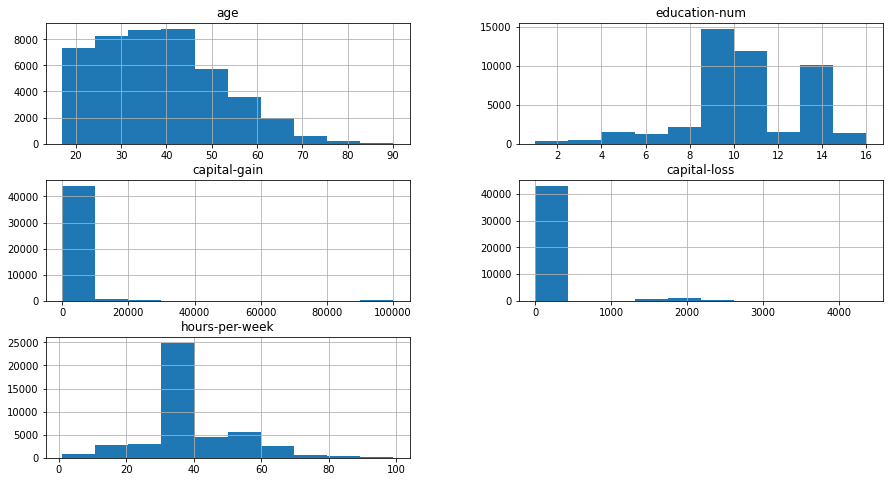

In [19]:
train_data.hist(figsize=(15,8))

In [20]:
cat_feats= ['workclass', 'education_level',
       'marital-status', 'occupation', 'relationship','native-country']

num_feats = ['capital-gain', 'capital-loss', 'hours-per-week','education-num']
feats_to_agg = ["race","native-country","workclass","education_level","marital-status","occupation"
                ,"relationship","sex","age_cats"]

### Feature Engineering
replacing features with ratio of occurance relative to the positive class

In [21]:
from sklearn.base import BaseEstimator,TransformerMixin

dictagg = {}

class update_dict_agg(BaseEstimator,TransformerMixin):
    def __init__(self,update_dict=False):
        self.update_dict = update_dict

    def fit(self,X,y=None):
        return self

    def get_agg_by_category(self,dataframe,column_name,sort_key=""):
        dtw=dataframe.pivot_table(index=column_name, columns="income", aggfunc=("size"),fill_value=0)
        dtw["total"]=dtw[">50K"] + dtw["<=50K"]
        dtw["ratio"]=dtw[">50K"] / dtw["total"]
        totalnum=np.sum(dtw["total"])
        dtw["coverage"]=dtw["total"]/totalnum
        dtw["rank"] = np.floor(dtw["ratio"] / 0.1)
        if sort_key !="":
            dtw = dtw.sort_values(sort_key)
        return dtw

    def transform(self,X):
        X["age_cats"]=np.floor(X["age"]/5)*5
        if self.update_dict:
            for feat in feats_to_agg:
                dictagg[feat]=dict(self.get_agg_by_category(X,feat,"ratio")['ratio'])
            X = X.drop('income',axis=1)
            
        return X

In [24]:
from sklearn.base import BaseEstimator,TransformerMixin


class features_adder(BaseEstimator,TransformerMixin):
    def __init__(self):
        pass

    def fit(self,X,y=None):
        return self

    def transform(self,X):
        dt3d=X

        if len(dt3d.columns) < 88:
            dt3d["age_cats"]=np.floor(dt3d["age"]/5)*5
        
        for clm in dt3d.columns:
            if clm in dictagg.keys():
                for category,aggcategory in dictagg[clm].items():
                    dt3d.loc[dt3d[clm]==category,clm] = aggcategory
        
        dt3d=dt3d.drop("education_level",axis=1)

        dt3d['capital-loss'] = np.log(dt3d['capital-loss'] +1 )
        dt3d['capital-gain'] = np.log(dt3d['capital-gain'] +1 )
        dt3d = pd.get_dummies(dt3d)
        
        return np.c_[dt3d]


Pipeline to add Features to new data and scale the data

In [25]:
from sklearn.preprocessing import OneHotEncoder,StandardScaler,LabelBinarizer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

train_data_agged = update_dict_agg(update_dict=True).transform(train_data)

full_pipline = Pipeline([
    ('feat_adder',features_adder()),
    ('scaler',StandardScaler())
])

X = full_pipline.fit_transform(train_data_agged)
y = np.where(train_data.income == '<=50K',0,1)


c:\Users\Muhammed\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\algorithms.py:798: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  uniques = Index(uniques)


performing Strattified Sampling to overcome the problem of The Dataset being skewed the number negative class instances is larger than the postive class

spliting data into train and valid sets

In [26]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1,test_size=0.2)

for train_index,test_index in split.split(X,y):
    X_train = X[train_index]
    y_train = y[train_index]
    X_val = X[test_index]
    y_val = y[test_index]

## Modeling

In [48]:
from sklearn.ensemble import RandomForestClassifier

rnd_clf = RandomForestClassifier(n_estimators=150,n_jobs=-1)
rnd_clf.fit(X_train,y_train)

RandomForestClassifier(n_estimators=150, n_jobs=-1)

In [49]:
print("Random Forest Score on valid Set = {:.2f}".format(rnd_clf.score(X_val,y_val)))

Random Forest Score on valid Set = 0.84


In [29]:
from sklearn.model_selection import GridSearchCV

param_grid = {"n_estimators":range(1,200,49),
"min_samples_leaf":range(5,25,10),
"max_features":[2,4,6],
}

rnd_clf = RandomForestClassifier()
gridcv = GridSearchCV(rnd_clf,param_grid=param_grid,scoring="roc_auc",cv=3,verbose=1)
gridcv.fit(X_train,y_train)

Fitting 3 folds for each of 30 candidates, totalling 90 fits


GridSearchCV(cv=3, estimator=RandomForestClassifier(),
             param_grid={'max_features': [2, 4, 6],
                         'min_samples_leaf': range(5, 25, 10),
                         'n_estimators': range(1, 200, 49)},
             scoring='roc_auc', verbose=1)

In [51]:
print("best model score from gridsearchcv = {:.2f}".format(gridcv.best_score_))

best model score from gridsearchcv = 0.91


In [31]:
rnd_clf_best = gridcv.best_estimator_

Training the model with only top 10 important features

In [32]:
most_imp_feats_idx = np.argsort(-rnd_clf_best.feature_importances_)[:10]

In [33]:
X_train_new = X_train[:,most_imp_feats_idx]

In [34]:
rnd_clf_best.fit(X_train_new,y_train)

RandomForestClassifier(max_features=6, min_samples_leaf=5, n_estimators=148)

In [35]:
X_val_new = X_val[:,most_imp_feats_idx]

In [36]:
y_val

array([1, 0, 0, ..., 1, 0, 0])

In [53]:
from sklearn.metrics import roc_auc_score
y_preds =rnd_clf_best.predict_proba(X_val_new)
print("best model auc score on valid set with only important feats = {:.2f}".format(roc_auc_score(y_val,y_preds[:,1])))

best model auc score on valid set with only important feats = 0.90


optimizing to get 90% precision

In [38]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import precision_recall_curve,precision_score

y_scores = cross_val_predict(rnd_clf,X_train,y_train,cv=3,method='predict_proba')

In [39]:
y_scores[:,1]

array([0.074, 0.982, 0.93 , ..., 0.04 , 0.916, 0.47 ])

In [40]:
precisions,recalls,thresholds = precision_recall_curve(y_train,y_scores[:,1])

In [55]:
t_90_precision = thresholds[np.argmax(precisions >=0.9)]
print("threshold that results in 90% precision = {:.2f}".format(t_90_precision))

threshold that results in 90% precision = 0.89


In [57]:
y_preds_90 = (y_scores[:,1] >= t_90_precision)
print("precision score on training set = {:.2f}".format(precision_score(y_train,y_preds_90)))


precision score on training set = 0.90


Making Predictions

In [43]:
test_data = test_data.drop('Unnamed: 0',axis=1)

In [45]:
test_transformed = full_pipline.transform(test_data)
test_transformed_new = test_transformed[:,most_imp_feats_idx]

from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy='mean')
test_transformed_new = imputer.fit_transform(test_transformed_new)
preds = rnd_clf_best.predict_proba(test_transformed_new)[:,1]

c:\Users\Muhammed\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\algorithms.py:798: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  uniques = Index(uniques)


In [46]:
df = pd.read_csv('example_submission.csv')
df['income'] = preds
df.to_csv('sub1.csv',index=False)